# Линейная регрессия

### Описание проекта:
Нобходимо защитить данные клиентов таким образом, чтобы это не влияло на качество модели
    
### Описание признаков:
    
* пол
* возраст
* зарплата
* члены семьи

### Целевой признак:

* страховые выплаты

### Выводы:
* для защиты данных матрица признаков умножалась на обратимую матрицу
* качество модели не изменилось
* коэффициенты изменились

## 0. Импорт библиотек

In [3]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score

SEED = 13
TRAIN_SIZE = .9
SHUFFLE_TRUE = True

## 1. Загрузите и изучите данные.

In [4]:
try:
    data = pd.read_csv('datasets/insurance.csv')  # Локальный путь
except:
    data = pd.read_csv('/datasets/insurance.csv')  # Серверный путь

In [5]:
print('Пропущенные значения')
for i, (k, v) in enumerate(data.isna().sum().items()):
    print('\t{}) {} --> {} пропущенных значений'.format(i+1, k, v))

Пропущенные значения
	1) Пол --> 0 пропущенных значений
	2) Возраст --> 0 пропущенных значений
	3) Зарплата --> 0 пропущенных значений
	4) Члены семьи --> 0 пропущенных значений
	5) Страховые выплаты --> 0 пропущенных значений


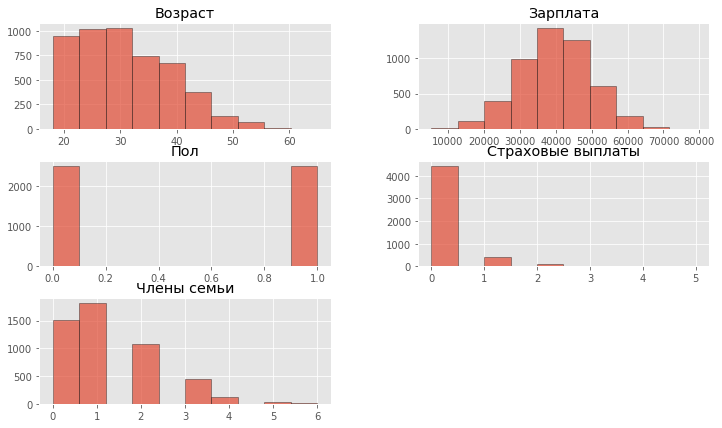

In [6]:
data.hist(edgecolor = 'black', alpha = .7, figsize =(12, 7));

* больше всего людей в возрасте ~30 лет, распределение скошено влево влево(с ростом возраста кол-во людей уменьшается)
* зарплата распределена примерно нормально, однаео, имеет тяжелые хвосты
* мужчин и женщин равное кол-во
* большинство людей не совершало страховых выплат
* больше всего семей с 1 ребенком, максимальное число детей - 6

In [7]:
X = data.drop('Страховые выплаты', 1)
y = data['Страховые выплаты']

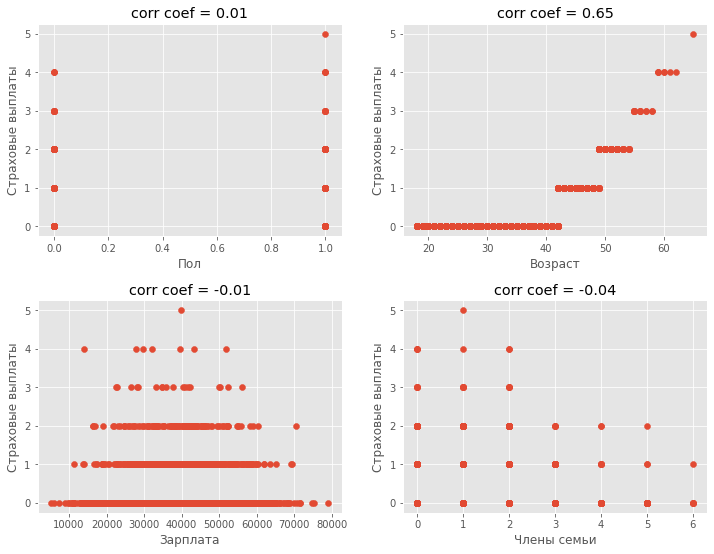

In [8]:
plt.figure(figsize = (12, 9))
for i, col in enumerate(X.columns):
    plt.subplot(2, 2, i+1)
    plt.scatter(X[col], y)
    corrcoef = X[[col]].corrwith(y).values[0]
    plt.title('corr coef = {:.2f}'.format(corrcoef))
    plt.xlabel(col)
    plt.ylabel('Страховые выплаты')
plt.subplots_adjust(hspace = .3)

* между признаками пол, зарпалата, члены семьи и целевым признаком практически нет линейной связи

## 2. Умножение матриц
Обозначения:

$X$ — матрица признаков (нулевой столбец состоит из единиц)

$y$ — вектор целевого признака

$P$ — матрица, на которую умножаются признаки

$w$ — вектор весов линейной регрессии (нулевой элемент равен сдвигу)

Предсказания:

$$
a = Xw
$$
Задача обучения:

$$
w = \arg\min_w MSE(Xw, y)
$$
Формула обучения:

$$
w = (X^T X)^{-1} X^T y
$$
Ответ: При умножении матрицы признаков на обратимую матрицу, качество линейной регресии не изменится.

Обоснование:

Допустим, что

$X^T X$ - это квадратная обратимая матрица.

$Z$ - обратимая по определению

$(AB)^T = B^T A^T$

$(AB)^{-1} = B^{-1}A^{-1} $

$AA^{-1} = A^{-1} A = E$ - руководствуемся этим тождеством при преобразовании выражения a'

Подставим $XZ$ вместо $X$ , так как нам нужно умножить матрицу $X (M, N)$ на обратимую матрицу $Z (N, M)$:

$$
w' = ((XZ)^T XZ)^{-1} (XZ)^T y
$$$$
a' = XZ((XZ)^T XZ)^{-1} (XZ)^T y = XZ(X^T Z^T XZ)^{-1} X^T Z^T y = XZ(X^T Z^T XZ)^{-1} X^T Z^T y = XZZ^{-1}(X^TX)^{-1} Z^TX^T y = XE(X^TX)^{-1} EX^T y = X(X^TX)^{-1} X^T y = Xw
$$
Так как $(X^TX)^{-1} X^T y = w$, то тогда выражения равны. В итоге получаем, что $a' = a$

## 3. Алгоритм преобразования

* получение X, y (признаков, целевой переменной)
* создание рандомной обратной матрицы
* обучение модели без преобразования
* получение метрики R2 на модели без преобразования
* умножение обратной матрицы на матрицу признаков
* обучение модели на преобразованых данных
* получение мерики R2 на преобразованых данных
* сравнение метрик
* обоснование

#### проверка влияния преобразования :
* умножим наши признаки на квадратную невырожденную матрицу и сравним качество линейной регресии на двух матрицах: умноженной на квадратную невырожденную матрицу и не умноженой на неё.

In [9]:
# делим данные на трейн, отложенную части
xtr, xhold, ytr, yhold = train_test_split(X, y, train_size = TRAIN_SIZE, shuffle = SHUFFLE_TRUE, random_state = SEED)

In [10]:
# создаем обратимую матрицу
nrows, ncols = xtr.shape[1], xtr.shape[1]
Z =np.random.normal(size = (nrows, ncols))
try:
    Z_inv = np.linalg.inv(Z)
except:
    raise ValueError('матрица необратима')

In [11]:
# считаем r2 для исходных признаков
linreg_pipe1 = Pipeline([('scaler', MinMaxScaler()), ('linreg', LinearRegression())])
linreg_pipe1.fit(xtr, ytr)
r2_raw = r2_score(yhold, linreg_pipe1.predict(xhold))

# считаем r2 для преобразованных признаков
linreg_pipe2 = Pipeline([('scaler', MinMaxScaler()), ('linreg', LinearRegression())])
linreg_pipe2.fit(xtr @ Z, ytr)
r2_inv = r2_score(yhold, linreg_pipe2.predict(xhold @ Z))

In [12]:
if np.isclose(r2_raw, r2_inv):
    print('преобразование не повлияло на качество')
else:
    print('преобразование повлияло на качество')

преобразование не повлияло на качество


In [13]:
if np.all([np.isclose(coef1 , coef2) for coef1, coef2\
                                     in zip(linreg_pipe1['linreg'].coef_,\
                                            linreg_pipe2['linreg'].coef_)]):
    print('коэффициенты не изменились')
else:
    print('коэффициенты изменились')

коэффициенты изменились
